In [1]:
#Importing the necessary libraries and modules.
%matplotlib inline
import xgboost
from xgboost import XGBRegressor as XGBR
from sklearn.svm import SVR as svr
from sklearn.linear_model import LinearRegression as Lr
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from itertools import combinations 
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, GridSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score,mean_absolute_error as MSE
import seaborn as sns
import sys
import warnings
warnings.filterwarnings("ignore")

E:\Anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#The version number of the library or software package being used.
!jupyter --version
print('Python: {}'.format(sys.version))#sys.version
print('Xgboost: {}'.format(xgboost.__version__))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))

jupyter core     : 4.7.1
jupyter-notebook : 6.3.0
qtconsole        : 5.0.3
ipython          : 7.22.0
ipykernel        : 5.3.4
jupyter client   : 6.1.12
jupyter lab      : 3.0.14
nbconvert        : 6.0.7
ipywidgets       : 7.6.3
nbformat         : 5.1.3
traitlets        : 5.0.5
Python: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Xgboost: 1.5.2
pandas: 1.4.2
numpy: 1.21.4
matplotlib: 3.3.4


In [4]:
#The column names of data set.
columns_list = ['NiMn', 'Ni', 'Mn', 'Sn', 'Fe', 'Co', 'Cu', 'Al', 'Numa', 'anum', 'Ven', 'avg Ven', 'En','Arc', 'mass', 'T']

#Retained features
L = ['Numa', 'Ven', 'avg Ven', 'En', 'Arc']

#Different combinations of features
result_list = sum([list(map(list, combinations(L, i))) for i in range(1, len(L)+1)], []) 
for i, features in enumerate(result_list):
    print(i, features)

0 ['Numa']
1 ['Ven']
2 ['avg Ven']
3 ['En']
4 ['Arc']
5 ['Numa', 'Ven']
6 ['Numa', 'avg Ven']
7 ['Numa', 'En']
8 ['Numa', 'Arc']
9 ['Ven', 'avg Ven']
10 ['Ven', 'En']
11 ['Ven', 'Arc']
12 ['avg Ven', 'En']
13 ['avg Ven', 'Arc']
14 ['En', 'Arc']
15 ['Numa', 'Ven', 'avg Ven']
16 ['Numa', 'Ven', 'En']
17 ['Numa', 'Ven', 'Arc']
18 ['Numa', 'avg Ven', 'En']
19 ['Numa', 'avg Ven', 'Arc']
20 ['Numa', 'En', 'Arc']
21 ['Ven', 'avg Ven', 'En']
22 ['Ven', 'avg Ven', 'Arc']
23 ['Ven', 'En', 'Arc']
24 ['avg Ven', 'En', 'Arc']
25 ['Numa', 'Ven', 'avg Ven', 'En']
26 ['Numa', 'Ven', 'avg Ven', 'Arc']
27 ['Numa', 'Ven', 'En', 'Arc']
28 ['Numa', 'avg Ven', 'En', 'Arc']
29 ['Ven', 'avg Ven', 'En', 'Arc']
30 ['Numa', 'Ven', 'avg Ven', 'En', 'Arc']


In [5]:
#Importing training set
data_train = pd.read_csv('C:/Users/a/Desktop/training set.csv') #The address for reading data needs to be modified.
xtrain = data_train.iloc[:, 1:15]
x1 = data_train.iloc[0:, 1:8]  #Only element content as features
ytrain = data_train.iloc[0:, 15:16] #label

#Importing test sets
data_test = pd.read_csv('C:/Users/a/Desktop/test set.csv') #The address for reading data needs to be modified.
xtest = data_test.iloc[:, 1:15]
x2 = data_test.iloc[:, 1:8]  #Only element content as features
ytest = data_test.iloc[:, 15:16] #laber

In [6]:
data_train.describe()

,Ni,Mn,Sn,Fe,Co,Cu,Al,Numa,anum,Ven,avg Ven,En,Arc,mass,T
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,44.827477,41.622703,10.613964,0.658108,1.627027,0.594595,0.049550,3.738739,29.053631,8.086868,0.278530,1.764117,1.293365,63.494190,295.676577
std,4.518164,5.681546,2.664362,1.701696,2.743785,1.711609,0.285681,0.583278,0.700563,0.162298,0.009747,0.021077,0.009008,1.712275,120.962169
min,36.000000,26.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,27.050000,7.840000,0.264527,1.727800,1.260000,58.242000,84.500000
25%,41.000000,37.000000,9.000000,0.000000,0.000000,0.000000,0.000000,3.000000,28.665000,7.960000,0.272483,1.743950,1.289200,62.577100,214.500000
50%,44.000000,40.000000,10.000000,0.000000,0.000000,0.000000,0.000000,4.000000,28.860000,8.082000,0.276328,1.766500,1.293250,63.126200,283.000000
75%,50.000000,47.000000,12.750000,0.000000,2.000000,0.000000,0.000000,4.000000,29.613000,8.141000,0.280937,1.781530,1.298845,64.827015,335.000000
max,51.200000,52.000000,15.500000,10.000000,11.000000,9.000000,2.000000,5.000000,30.375000,8.770000,0.324214,1.815400,1.309250,66.699350,730.500000


In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   NiMn     111 non-null    object 
 1   Ni       111 non-null    float64
 2   Mn       111 non-null    float64
 3   Sn       111 non-null    float64
 4   Fe       111 non-null    float64
 5   Co       111 non-null    float64
 6   Cu       111 non-null    float64
 7   Al       111 non-null    float64
 8   Numa     111 non-null    int64  
 9   anum     111 non-null    float64
 10  Ven      111 non-null    float64
 11  avg Ven  111 non-null    float64
 12  En       111 non-null    float64
 13  Arc      111 non-null    float64
 14  mass     111 non-null    float64
 15  T        111 non-null    float64
dtypes: float64(14), int64(1), object(1)
memory usage: 14.0+ KB


In [8]:
#Data set shuffling method for k-CV of different models
dict_random_state = {
    'Lr/3-cv': [*range(4, 50, 10)],
    'Lr/5-cv': [*range(10, 60, 10)],
    "svr/3-cv": [*range(0, 25, 5)],
     "svr/5-cv": [*range(1, 20, 4)],
     "RFR/3-cv": [*range(5, 30, 5)],
     "RFR/5-cv": [*range(0, 25, 5)],
     'XGBR/3-cv': [*range(5, 30, 5)],
     'XGBR/5-cv': [*range(40, 65, 5)]
    }

#Different model instantiations are used for K-CV
dict_modelclf = {
    'Lr/3-cv': Lr(),
    'Lr/5-cv': Lr(),
    "svr/3-cv": svr(kernel='linear'),
     "svr/5-cv": svr(kernel='linear'),
     "RFR/3-cv": RFR(random_state=0),
     "RFR/5-cv": RFR(random_state=0),
     'XGBR/3-cv': XGBR(n_estimators=147, learning_rate=0.1, random_state=0), #The optimal parameters obtained by grid search method
     'XGBR/5-cv': XGBR(n_estimators=147, learning_rate=0.1, random_state=0)
}


'''
#The optimal feature combination of different models, 
#where the number is the index of the feature combination in result_list.
'''
dict_featurebest= {
    'Lr/3-cv': 29,
    'Lr/5-cv': 29,
    "svr/3-cv": 4,
     "svr/5-cv": 4,
     "RFR/3-cv": 8,
     "RFR/5-cv": 8,
     'XGBR/3-cv':19 ,
     'XGBR/5-cv': 19,
}

'''
Instantiation of the different models, the optimal combination of features and the model name, 
where the number is the index of the combination of features in the result_list.
'''
four_model = [
    [Lr(), 29, 'LinearRegression'],
    [svr(kernel='linear'), 4, 'SVR.Linear'],
    [RFR(random_state=0), 8, 'RandomForestRegressor'],
    [XGBR(n_estimators=147, learning_rate=0.1, random_state=0), 19, 'XGBRegressor']
    ]

0.713 6.887


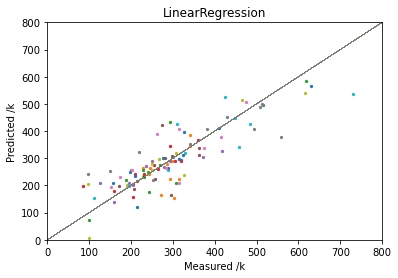

0.641 6.913


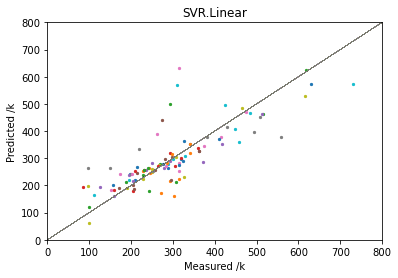

0.883 5.549


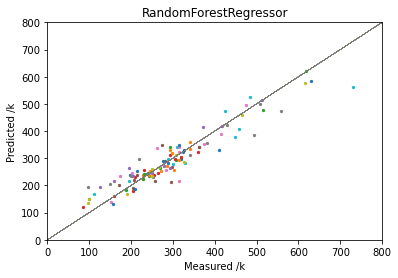

0.903 5.4


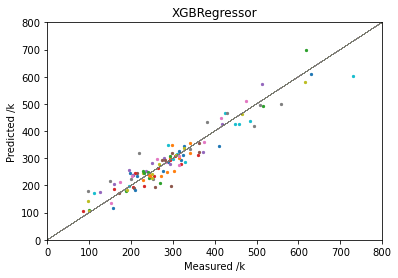

In [9]:
'''
Comparison of the predicted value and the true value of Tm obtained by the LOO-CV 
of different models (LR, SVR.linear, RFR, and XGBR).
'''
for Model in four_model:
    data1 = xtrain.loc[:, result_list[Model[1]]]
    x = pd.concat([x1, data1], axis=1)
    x = np.array(x)
    y = np.array(ytrain)
    
    model = Model[0]
    loo = LeaveOneOut()
    a_test, b_pre = [], []
    for train, test in loo.split(x,y):
        train_X, test_X, train_y, test_y = x[train], x[test], y[train], y[test]
        model = model.fit(train_X, train_y)
        predicted = model.predict(test_X)
        plt.title(Model[2])
        plt.scatter(test_y, predicted, s=5)
        plt.xlim(0, 800)
        plt.ylim(0, 800)
        plt.xlabel("Measured /k")
        plt.ylabel("Predicted /k")
        plt.plot(range(800), range(800), linewidth=0.1)
        a_test.append(test_y)
        b_pre.append(predicted)
        
    a_test = np.ravel(a_test)
    b_pre = np.ravel(b_pre)
    R2 = r2_score(a_test, b_pre)
    RMSE = np.sqrt(MSE(a_test, b_pre))
    
    print(round(R2, 3),round(RMSE, 3))
    plt.show()

In [10]:
'''
To verify the generalization of each model using K-fold (3-fold and 5-fold) Cross-Validation. 
To reduce the occasionality of dividing the data set by K-fold Cross-Validation, 
3-fold and 5-fold Cross-Validation have been used to do five times cross-validations, re-shuffle the 
data set each time, and finally take the average score of five Cross-Validations.
'''
for i in dict_random_state:
    scores = []
    data0 = xtrain.loc[:, result_list[dict_featurebest[i]]]
    x = pd.concat([x1, data0], axis=1)
    x = np.array(x)
    y = np.array(ytrain)
    
    for j in dict_random_state[i]:
        clf = dict_modelclf[i]
        r2_list = []
        r2 = []
        KF = KFold(shuffle=True, random_state=j, n_splits=int(i.split('/')[1][0]))
        for train, val in KF.split(x):
            X_train = x[train]
            y_train = y[train]
            X_val = x[val]
            y_val = y[val]
            clf = clf.fit(X_train, y_train)
            predicted = clf.predict(X_val)
            r2_list.append(r2_score(y_val, predicted))
        r2 = np.mean(r2_list)
        scores.append(r2)
        
    print(i, round(np.mean(scores), 3))

Lr/3-cv 0.675
Lr/5-cv 0.648
svr/3-cv 0.613
svr/5-cv 0.608
RFR/3-cv 0.818
RFR/5-cv 0.819
XGBR/3-cv 0.838
XGBR/5-cv 0.869


In [11]:
#The training set and test set are treated by the same ways.
data2 = xtrain.loc[:, result_list[19]]
data3 = xtest.loc[:, result_list[19]]
Xtrain = pd.concat([x1, data2], axis=1)
x2_test = pd.concat([x2, data3], axis=1)

#Train the entire training set and predict the test set using XGBR model
clff = XGBR(n_estimators=147, learning_rate=0.1, random_state=0).fit(Xtrain, ytrain)
y2_pre = clff.predict(x2_test)

In [12]:
#Compare the true and predicted values of the test set.
test_pre = pd.concat([data_test.loc[:, ['NiMn']], ytest, pd.DataFrame(y2_pre)], axis=1)
test_pre.rename(columns={'T': 'True', 0: 'predict'}, inplace=True)
test_pre

,NiMn,True,predict
0,Ni50Mn36.5Sn13.5,282.0,287.080750
1,Ni43Mn46Sn10Al1,262.5,276.705444
2,Ni45.3Mn35.9Cu4.5Sn14.3,159.0,155.898926
3,Ni45Mn39Fe5Sn11,295.0,309.107025
4,Ni50Mn41Sn8Co1,544.0,529.045654
